# Car Price Prediction Model
This data was collected from - https://www.kaggle.com/datasets/athirags/car-data

In [28]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

In [29]:
# necessary functions defined
def outlier_remover(data,col):
    Q1 = data[col].quantile(.25)
    Q3 = data[col].quantile(.75)
    IQR = Q3-Q1
    lower_fence = Q1- 1.5*IQR
    upper_fence = Q3+ 1.5*IQR
    return data[(data[col]<upper_fence) & (data[col]>lower_fence)]

# Data Checkup
## Importing Data

In [30]:
# data import
car_init = pd.read_csv('cardata_prediction.csv')
car = car_init.copy()
display(car.head())
display(car.info())

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


None

There is no null values, 4 object type columns and other numericals

## Categorical Columns Checkup

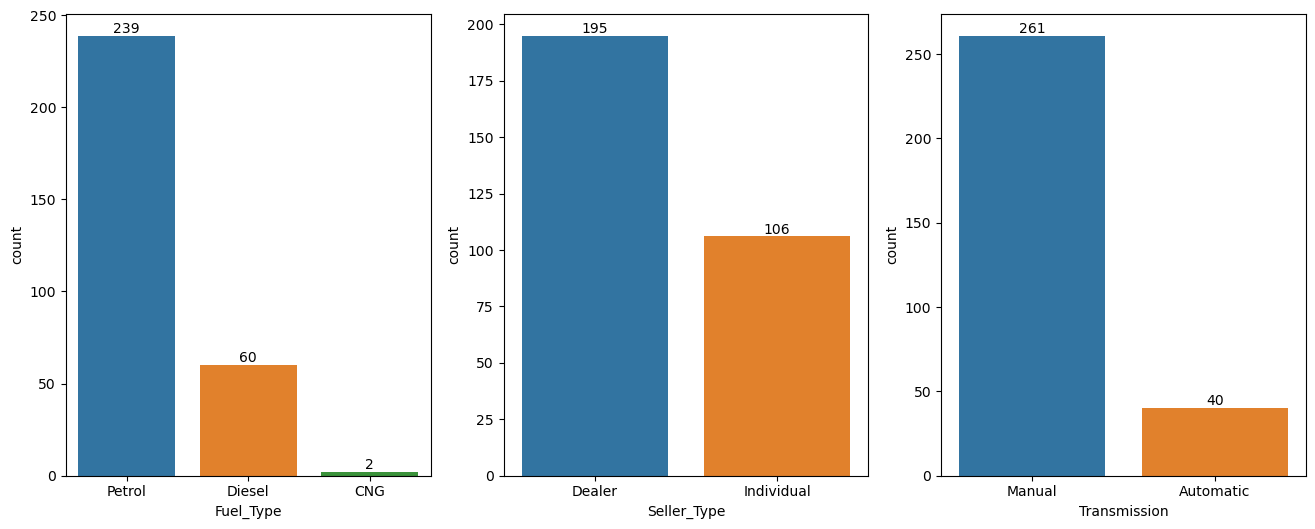

In [31]:
fig, ax = plt.subplots(1,3,figsize=(16,6))
i=0
for col in ['Fuel_Type','Seller_Type','Transmission']:
    sns.countplot(data=car,x=col,ax=ax[i])
    for label in ax[i].containers:
        ax[i].bar_label(label)
    i=i+1

## Correlation

<Axes: >

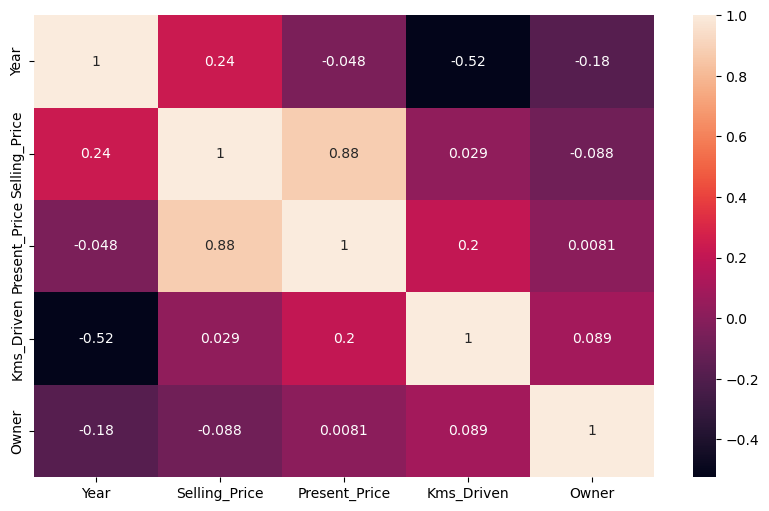

In [32]:
plt.figure(figsize=(10,6))
sns.heatmap(car.select_dtypes(exclude='object').corr(),annot=True)

There seems to be stong correlation between selling price and present price.

## Distributions

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
mean,2013.627907,4.661296,7.628472,36947.20598,0.043189
min,2003.000000,0.100000,0.320000,500.00000,0.000000
max,2018.000000,35.000000,92.600000,500000.00000,3.000000


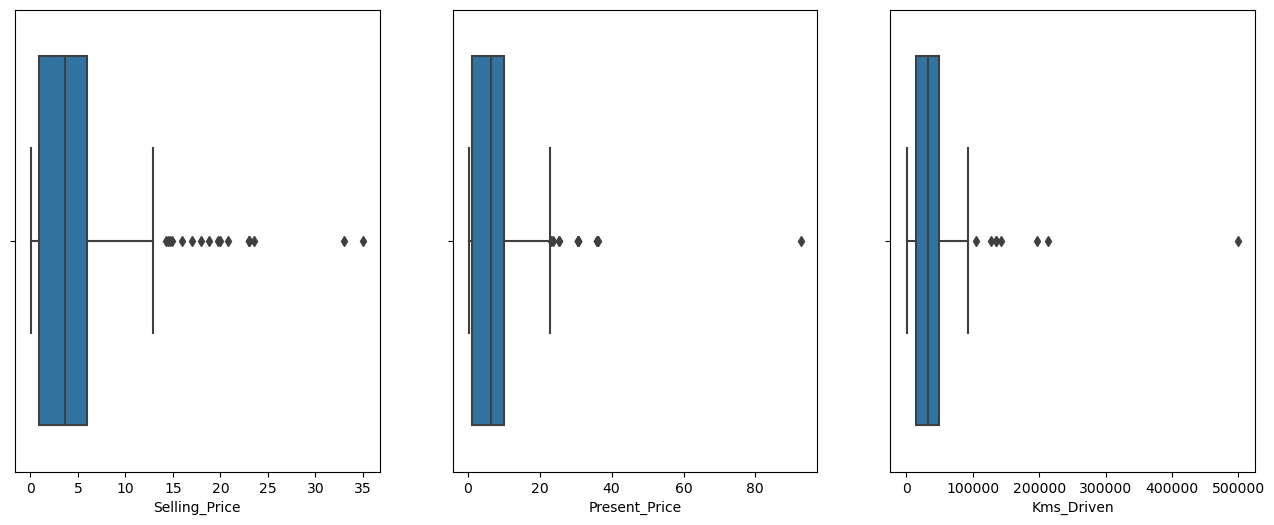

In [33]:
display(car.describe().loc[['mean','min','max']])
fig, ax = plt.subplots(1,3,figsize=(16,6))
i=0
for col in ['Selling_Price','Present_Price','Kms_Driven']:
    sns.boxplot(data=car,x=col,ax=ax[i])
    i=i+1

## Outlier Removal and Distribution After Removal

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,276.00,276.00,276.00,276.00,276.00
mean,2013.75,3.75,6.01,32120.91,0.04
min,2003.00,0.10,0.32,500.00,0.00
max,2018.00,12.90,20.45,92233.00,1.00


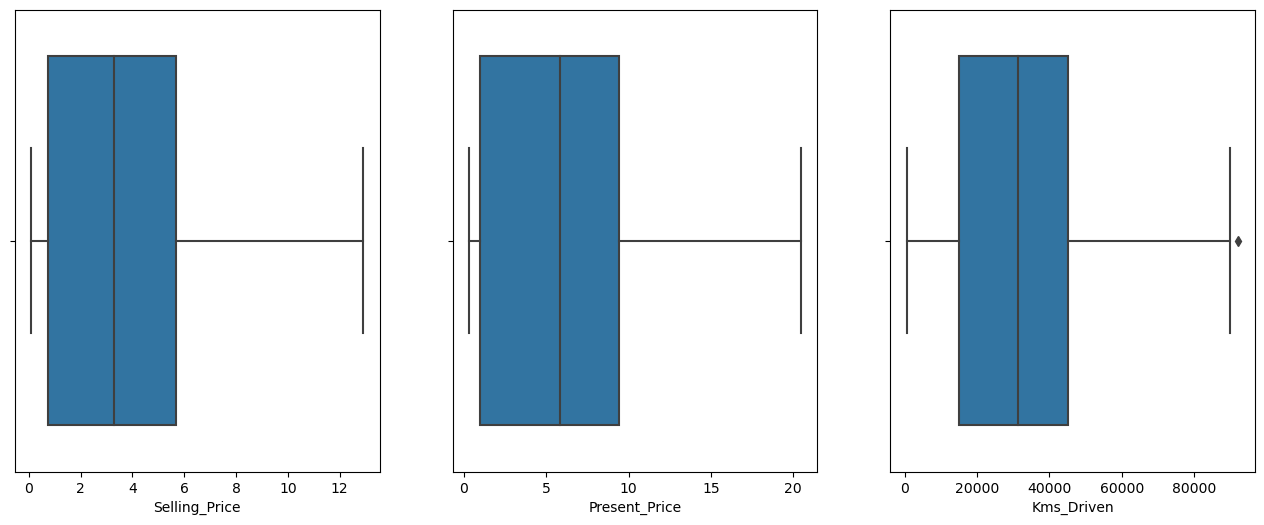

In [34]:
# car = car[car['Selling_Price']<25]
# car = car[car['Present_Price']<40]
# car = car[car['Kms_Driven']<300000]
car = outlier_remover(car,'Selling_Price')
car = outlier_remover(car,'Present_Price')
car = outlier_remover(car,'Kms_Driven')
fig, ax = plt.subplots(1,3,figsize=(16,6))
i=0
for col in ['Selling_Price','Present_Price','Kms_Driven']:
    sns.boxplot(data=car,x=col,ax=ax[i])
    i=i+1
display(car.describe().loc[['count','mean','min','max']].round(2))

## Using Pairplot to Find Relations Between Column

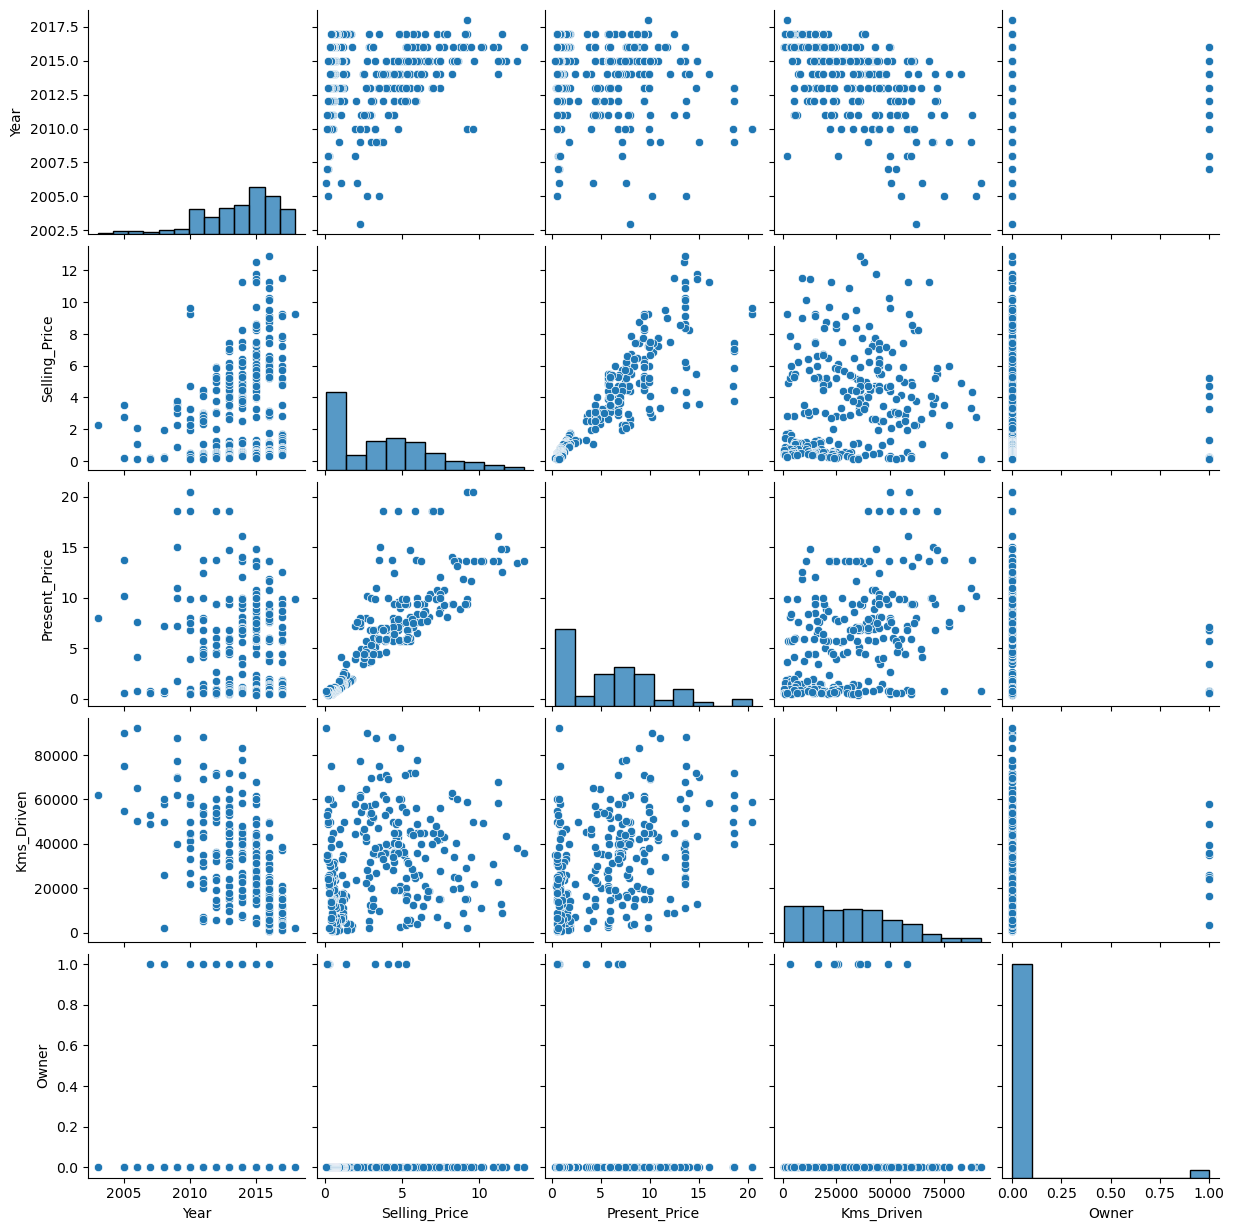

In [35]:
sns.pairplot(car)

# Data Preprocessing

**Transmission Data:**<br>
Manual - 0<br>
Automatic - 1

**Seller Type:**<br>
Dealer - 0<br>
Individual - 1

**Fuel Type:** Used One HotCode Encoder

In [36]:
car['Transmission'] = car['Transmission'].replace(['Manual','Automatic'],[0,1])
car['Seller_Type'] = car['Seller_Type'].replace(['Dealer','Individual'],[0,1])
car['Age'] = datetime.date.today().year - car['Year']
car = car.drop(columns=['Car_Name','Year']).copy()
car = pd.get_dummies(car)
display(car.head())
display(car.info())


,Selling_Price,Present_Price,Kms_Driven,Seller_Type,Transmission,Owner,Age,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_Petrol
0,3.35,5.59,27000,0,0,0,9,False,False,True
1,4.75,9.54,43000,0,0,0,10,False,True,False
2,7.25,9.85,6900,0,0,0,6,False,False,True
3,2.85,4.15,5200,0,0,0,12,False,False,True
4,4.60,6.87,42450,0,0,0,9,False,True,False


<class 'pandas.core.frame.DataFrame'>
Index: 276 entries, 0 to 300
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Selling_Price     276 non-null    float64
 1   Present_Price     276 non-null    float64
 2   Kms_Driven        276 non-null    int64  
 3   Seller_Type       276 non-null    int64  
 4   Transmission      276 non-null    int64  
 5   Owner             276 non-null    int64  
 6   Age               276 non-null    int64  
 7   Fuel_Type_CNG     276 non-null    bool   
 8   Fuel_Type_Diesel  276 non-null    bool   
 9   Fuel_Type_Petrol  276 non-null    bool   
dtypes: bool(3), float64(2), int64(5)
memory usage: 18.1 KB


None

## Standarized Data and Split for Train and Test

In [37]:
X = car.drop(columns='Selling_Price').values
y = car['Selling_Price'].values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=69)

# Fitting Models
## Check Different Models Scores

In [38]:
models = [LinearRegression(),Lasso(),Ridge(),DecisionTreeRegressor(),RandomForestRegressor()]
model_name = []
rmse = []
r_square = []
for model in models:
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    model_name.append(model.__class__.__name__)
    rmse.append(mean_squared_error(y_test,y_pred,squared=False))
    r_square.append(r2_score(y_test,y_pred))

results = pd.DataFrame({'Models':model_name,'RMSE':rmse,'R-Squared':r_square})
results

,Models,RMSE,R-Squared
0,LinearRegression,0.843431,0.915735
1,Lasso,2.750788,0.103683
2,Ridge,0.876911,0.908913
3,DecisionTreeRegressor,1.040748,0.871696
4,RandomForestRegressor,0.829063,0.918582


Linear Regression and Random Forest Regressor seems to have the highest performance. Let's see if we can hypertune the parameters of Random Forest Regressor to make the model more accurate.

## Hypertunig Random Forest Regressor

In [39]:
regressor = RandomForestRegressor()
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'max_depth': [None, 5, 10, 15, 20, 25],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 8]
}
model = RandomizedSearchCV(estimator=regressor, param_distributions=param_grid, cv=5, n_iter=10,random_state=69,n_jobs=-1)
model.fit(X_train,y_train)
display(model.best_params_)
y_pred = model.predict(X_test)
print('Model Best Score:',model.best_score_,'\nRMSE:',mean_squared_error(y_test,y_pred,squared=False),'\nR-Squared:',r2_score(y_test,y_pred))

{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 5}

Model Best Score: 0.941032595851923 
RMSE: 0.8515614344995753 
R-Squared: 0.9141027082311086


It seems to have a little better performance. So let's use this to predict new values with estimated best parameters

## Fitting Model and Show Graph

<Axes: >

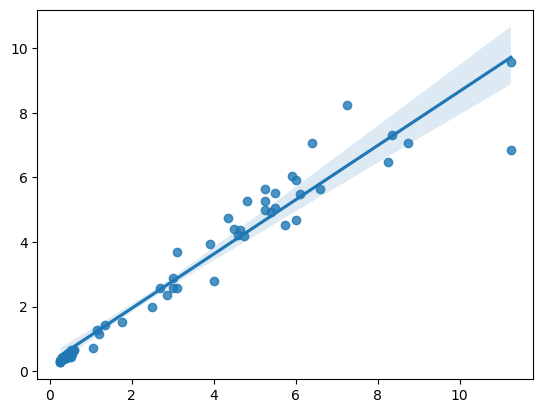

In [40]:
regressor = RandomForestRegressor(n_estimators= 300,min_samples_split= 2,min_samples_leaf= 1,max_depth= 5)
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)
sns.regplot(x=y_test,y=y_pred,ci=95)

# Predict New Data

In [41]:
Year = 2017 # Which years model
Present_Price = 12.5 # present price in thousands
Kms_Driven = 9000 # KM driven
Seller_Type = 1 # Seller Type- 0 if Dealer,  1 if Individual.
Transmission = 1 # Transmission - 0 if Manual,  1 if Automatic.
Owner = 0 # How many owners were before

# Fuel Type - 1 if that's the fuel type else 0.
Fuel_Type_CNG = 1
Fuel_Type_Diesel = 0
Fuel_Type_Petrol = 0





Age = datetime.date.today().year - Year
y_new = [Present_Price,Kms_Driven,Seller_Type,Transmission,Owner,Age,
         Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_Petrol]
y_new_scaled = scaler.transform([y_new])
Selling_Price = regressor.predict(y_new_scaled)
print('Selling Price: ',Selling_Price[0].round(2))

Selling Price:  10.19
